# Hyperopt 入门指南

Hyperopt：是进行超参数优化的一个类库。有了它我们就可以拜托手动调参的烦恼，并且往往能够在相对较短的时间内获取原优于手动调参的最终结果。



一般而言，使用hyperopt的方式的过程可以总结为：

 - 用于最小化的目标函数
 - 搜索空间
 - 存储搜索过程中所有点组合以及效果的方法
 - 要使用的搜索算法

## 目标函数
### 一个简单的例子

这里是一个简单的例子，用来展示函数问题

In [1]:
from hyperopt import fmin, tpe, hp
best = fmin(
    fn=lambda x: x,
    space=hp.uniform('x', -2.5, 2.5),
    algo=tpe.suggest,
    max_evals=100)
print(best)

{'x': -2.4988538280500032}


**我们来分解一下这个例子。**

函数fmin首先接受一个函数来最小化，记为fn，在这里用一个匿名函数lambda x: x来指定。该函数可以是任何有效的值返回函数，例如回归中的平均绝对误差。

下一个参数指定搜索空间，在本例中，它是0到1之间的连续数字范围，由hp.uniform('x', 0, 1)指定。hp.uniform是一个内置的hyperopt函数，它有三个参数：名称x，范围的下限和上限0和1。

algo参数指定搜索算法，本例中tpe表示 tree of Parzen estimators。该主题超出了本文的范围，但有数学背景的读者可以细读[这篇文章](https://arxiv.org/abs/1209.5111)。algo参数也可以设置为hyperopt.random，但是这里我们没有涉及，因为它是众所周知的搜索策略。但在未来的文章中我们可能会涉及。

最后，我们指定fmin函数将执行的最大评估次数max_evals。这个fmin函数将返回一个python字典。
上述函数的一个输出示例是{'x': 0.0011494865292422545}。

以下是该函数的图。红点是我们试图找到的点。

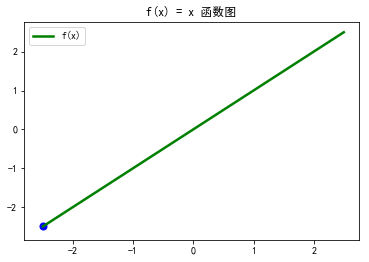

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# 为随机数固定一个数值
np.random.RandomState(seed=42)

plt.rcParams["font.sans-serif"] = ['SimHei']  # 用于正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

x = np.linspace(-2.5, 2.5, 256, endpoint=True)  # 绘制X轴（-2.5,2）的图像

f = x  # y值

plt.plot(x, f, "g-", lw=2.5, label="f(x)")
plt.scatter(best['x'], best['x'], 50, color='blue')
plt.title('f(x) = x 函数图')
plt.legend()
plt.show()

### 更复杂的例子-单独定义目标函数

我们这里展示一个更为复杂的例子——$f(x) = sin^2(x-2)e^{-x^2}$，并且将fn定义为python中的函数。同时这里我们还需要通过负号将最大化问题转化为最小化问题。

{'x': 0.21602283343494763}


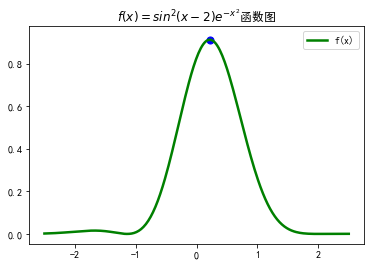

In [3]:
from hyperopt import fmin, tpe, hp


def fun_change(x):
    y = (np.sin(x - 2))**2 * (np.e)**(-x**2)
    return -y


best = fmin(
    fn=fun_change,
    space=hp.uniform('x', -2.5, 2.5),
    algo=tpe.suggest,
    max_evals=100)
print(best)

x = np.linspace(-2.5, 2.5, 256, endpoint=True)  # 绘制X轴（-2.5,2）的图像

f = (np.sin(x - 2))**2 * (np.e)**(-x**2)  # y值

plt.plot(x, f, "g-", lw=2.5, label="f(x)")
plt.scatter(best['x'], -fun_change(best['x']), 50, color='blue')
plt.title('$f(x) = sin^2(x-2)e^{-x^2}$函数图')
plt.legend()
plt.show()

使用上面的方法，我们就可以传入更加复杂的函数，或者某个其他类库中单独定义的函数，如sklearn中的SVC，RF，亦或是XGBoost或者LightGBM，并在对该函数进行搜索。不过假如真的使用sklearn中的机器学习模型的话，那就会存在另外一个问题，很明显，一般的机器学习模型都不止一个超参数。那么我们又应该怎么传入更多的超参数呢。

(Note：不过假如想要完美的使用xgb或者lgb还存在其他问题，这个我们会在其他文章里详细描述使用方法）


## 参数空间

### 如何定义
想要同时传入两个超参数，我们首先要了解参数空间的概念。在Hyperopt中的参数空间需要使用`hyperopt.hp`下的函数进行定义。

hyperopt的hp包含很多用来定义参数空间的函数。之前我们已经使用过其中hp.uniform，该函数是返回位于`[low,hight]`之间的均匀分布的值。除此之外比较常用的还有randint：返回0到参数之间的整数，choice，从列表中选择，该函数可以用于传入字符串参数。

常用函数如下：
 - hp.choice(label, options)

	- 返回传入的列表或者数组其中的一个选项。

 - hp.randint(label, upper)

	- 返回范围:[0，upper]中的随机整数。

 - hp.uniform(label, low, high)

	- 返回位于[low,hight]之间的均匀分布的值。
	- 在优化时，这个变量被限制为一个双边区间。
    
 - hp.normal(label, mu, sigma)

	- 返回正态分布的实数值，其平均值为 `mu` ，标准偏差为 `σ`。优化时，这是一个无边界的变量。
    
除此之外其实还有很多其他方法可以使用。这里不再做更多介绍。详细内容可以参考本人翻译的Hyperopt中文文档。（已通过issues获得授权）

In [4]:
import hyperopt.pyll.stochastic

space = {
    'x': hp.uniform('x', 0, 1),
    'y': hp.normal('y', 0, 1),
    'name': hp.choice('name', ['alice', 'bob']),
}

print(hyperopt.pyll.stochastic.sample(space))

{'name': 'alice', 'x': 0.5383149551265306, 'y': 0.05463630170554273}


### 代码实现与具体实现
而对于数个传入的超参数，很明显假设这也是一个函数的话，其极大概率是非凸的，而如贝叶斯优化等现代优化算法则是专门处理此类问题的。在搜索一开始的时候，hyperopt会默认进行随机搜索，但是Hyperopt会在搜索过程中对函数的输出进行预估，然后不断地根据之前的结果，调整搜索空间。

**之前说过为了向fmin中传入更多的超参数，我们还可以对参数空间进行扩展，而下面就是一个同时对两个参数进行优化的例子。其使用十分简单**

{'x': 2.498647148053222, 'y': 2.4999021654689324}


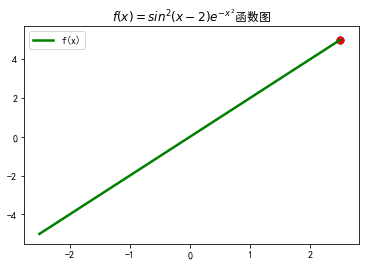

In [5]:
def fun_change(space):
    f = space['x'] + space['y']
    return -f


space = {
    "x": hp.uniform('x', -2.5, 2.5),
    "y": hp.uniform('y', -2.5, 2.5),
}

best = fmin(fn=fun_change, space=space, algo=tpe.suggest, max_evals=1000)
print(best)

x = np.linspace(-2.5, 2.5, 256, endpoint=True)  # 绘制X轴（-2.5,2.5）的图像
y = np.linspace(-2.5, 2.5, 256, endpoint=True)  # 绘制X轴（-2.5,2.5）的图像

f = x + y  # y值

plt.plot(x, f, "g-", lw=2.5, label="f(x)")
plt.scatter(best['x'], -fun_change(best), 50, color='blue')
plt.scatter(best['x'], -fun_change(best), 50, color='red')
plt.title('$f(x) = sin^2(x-2)e^{-x^2}$函数图')
plt.legend()
plt.show()

### 与sklearn结合

在做到这一步的时候，我们已经可以通过将hyperopt和sklearn结合以获取我们想要的超参数组合。这里我们首先来获取数据集，这里使用的是非常经典的iris数据集。

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
  species   measurement  value
0  setosa  sepal_length    5.1
1  setosa  sepal_length    4.9
2  setosa  sepal_length    4.7
3  setosa  sepal_length    4.6
4  setosa  sepal_length    5.0


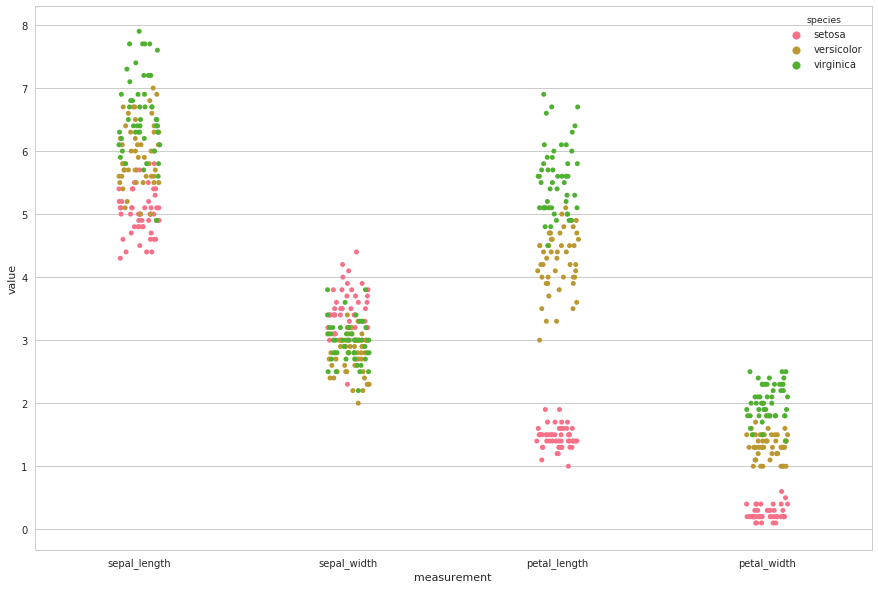

In [6]:
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid", palette="husl")

iris = sns.load_dataset("iris")
print(iris.head())

iris = pd.melt(iris, "species", var_name="measurement")
print(iris.head())

f, ax = plt.subplots(1, figsize=(15,10))
sns.stripplot(x="measurement", y="value", hue="species", data=iris, jitter=True, edgecolor="white", ax=ax)

上面的代码展示了iris数据集，而后边的代码则是Hyperopt对sklearn中分类决策树的调参实例。

In [48]:
from sklearn import datasets
from sklearn.preprocessing import normalize, scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
# 这里的warnings实在太多了，我们加入代码不再让其显示
import warnings
warnings.filterwarnings("ignore")

from hyperopt import Trials
iris = datasets.load_iris()
X = iris.data
y = iris.target


def hyperopt_model_score_dtree(params):
    X_ = X[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']
    clf = DecisionTreeClassifier(**params)
    return cross_val_score(clf, X_, y).mean()


space_dtree = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'max_features': hp.choice('max_features', range(1, 5)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}


def fn_dtree(params):
    acc = hyperopt_model_score_dtree(params)
    return -acc

# 为可视化做准备
trials = Trials()
best = fmin(
    fn=fn_dtree, space=space_dtree, algo=tpe.suggest, max_evals=1000, trials=trials)
print('best:')
print(best)

best:
{'criterion': 0, 'max_depth': 17, 'max_features': 1, 'normalize': 0, 'scale': 0}


In [49]:
params = {'criterion': "gini", 'max_depth': 18, 'max_features': 2}
clf = DecisionTreeClassifier(**params)
print(cross_val_score(clf, X, y).mean())

0.9669117647058822


**解析上面的例子**

首先最关键的还是最小化的目标函数，我们这里构建的目标函数中测试的是sklearn中的分类决策树，而目标函数返回的结果则是交叉验证的平均损失。

然后是参数空间的问题，如之前所写，这里只需要定义一个space然后穿入fmin即可。对于字符串的超参数，我们这里使用`hp.choice`解决该问题，**同时要注意的是：假如构建参数空间使用'hp.choice'函数的，那么在模型中返回的将是传入列表或者数组的index（索引）,而且是从0开始的，在测试最终结果时候一定要注意这一点**。为了检测标准化和归一化时候有用，我们这里额外添加了两个参数"scale"和"normalize"，而其对与分类决策树的影响则定义于目标函数部分。

但是hyperopt进行的参数选择到底是怎么样影响我们的模型的呢？

## 可视化

目前看，hyperopt对于我们已经是个黑箱。但是我们也可以通过传入`Trials`来获取搜索过程中的结果。而通过可视化该结果，我们也可以对参数和模型的关系有更好地了解。

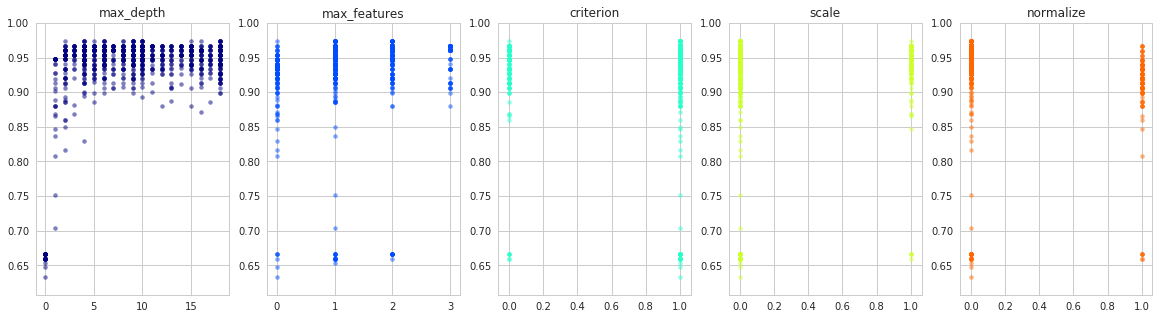

In [11]:
parameters = ['max_depth', 'max_features', 'criterion', 'scale',
              'normalize']  # decision tree
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20, 5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    ys = np.array(ys)
    axes[i].scatter(
        xs,
        ys,
        s=20,
        linewidth=0.01,
        alpha=0.5,
        c=cmap(float(i) / len(parameters)))
    axes[i].set_title(val)

通过上面的例子我们可以看出scale和normalize在这里基本没有什么影响。而其他参数的影响也可以比较好的看出。这在进行进一步的搜索的时候，将会非常有用。因为我们可以通过图像获得一个更小的参数搜索范围。然后同样的事情，我们再做一次，模型替代为SVM。

best:
{'C': 3.383042170158757, 'gamma': 2.4082659264264454, 'kernel': 3, 'normalize': 1, 'scale': 0}


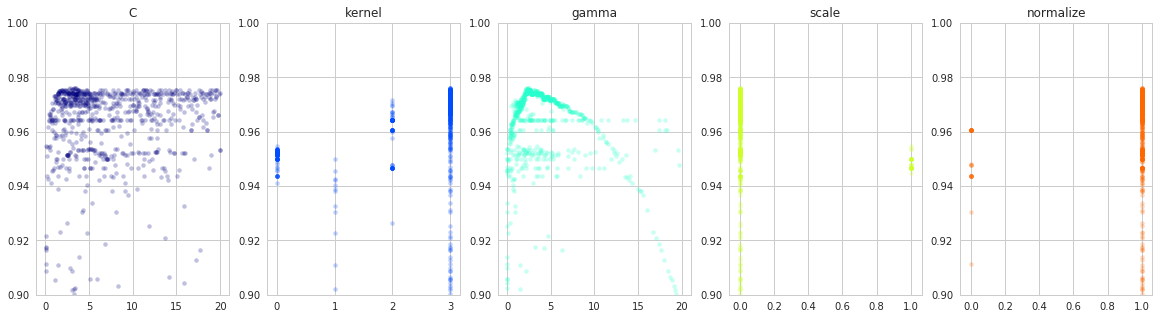

In [44]:
def hyperopt_model_score_svm(params):
    X_ = X[:]

    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
        del params['normalize']

    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
        del params['scale']

    clf = SVC(**params)
    return cross_val_score(clf, X_, y).mean()


space_svm = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 20),
    'scale': hp.choice('scale', [0, 1]),
    'normalize': hp.choice('normalize', [0, 1])
}


def f_svm(params):
    acc = hyperopt_model_score_svm(params)
    return -acc


trials = Trials()
best = fmin(f_svm, space_svm, algo=tpe.suggest, max_evals=1000, trials=trials)
print('best:')
print(best)

parameters = ['C', 'kernel', 'gamma', 'scale', 'normalize']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(20, 5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    axes[i].scatter(
        xs,
        ys,
        s=20,
        linewidth=0.01,
        alpha=0.25,
        c=cmap(float(i) / len(parameters)))
    axes[i].set_title(val)
    axes[i].set_ylim([0.9, 1.0])

In [47]:
params = {'C': 3.383042170158757, 'gamma': 2.4082659264264454, 'kernel': "poly"}
clf = SVC(**params)
print(cross_val_score(clf, normalize(X), y).mean())

0.9643956205831742


### 将一切融合为一体

将一切融合为一体，也就是说将模型本身也作为超参数进行优化，返回的结果将是最好的那个模型以及其最佳参数组合。但是这样做存在一个问题。例子如下。

In [28]:
digits = datasets.load_digits()
X = digits.data
y = digits.target
print(X.shape, y.shape)


from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    if t == 'naive_bayes':
        clf = BernoulliNB(**params)
    elif t == 'svm':
        clf = SVC(**params)
    elif t == 'dtree':
        clf = DecisionTreeClassifier(**params)
    elif t == 'knn':
        clf = KNeighborsClassifier(**params)
    else:
        return 0
    return cross_val_score(clf, X, y).mean()

space = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
        'alpha': hp.uniform('alpha', 0.0, 2.0)
    },
    {
        'type': 'svm',
        'C': hp.uniform('C', 0, 10.0),
        'kernel': hp.choice('kernel', ['linear', 'rbf']),
        'gamma': hp.uniform('gamma', 0, 20.0)
    },
    {
        'type': 'dtree',
        'max_depth': hp.choice('max_depth', range(1, 20)),
        'max_features': hp.choice('max_features', range(1, 5)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
    },
    {
        'type': 'knn',
        'n_neighbors': hp.choice('knn_n_neighbors', range(1,50))
    }
])

count = 0
best = 0
def f(params):
    global best, count
    count += 1
    acc = hyperopt_train_test(params.copy())
    if acc > best:
        print('new best:', acc, 'using', params['type'])
        print('iters:', count, ', acc:', acc, 'using', params)
        best = acc
    if count % 50 == 0:
        print('iters:', count, ', acc:', acc, 'using', params)
    return -acc

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=1500, trials=trials)
print('best:')
print(best)

(1797, 64) (1797,)
new best: 0.9437997276286755 using svm
iters: 1 , acc: 0.9437997276286755 using {'C': 9.103691443113167, 'gamma': 16.473379775097474, 'kernel': 'linear', 'type': 'svm'}
new best: 0.9438221642590143 using knn
iters: 4 , acc: 0.9438221642590143 using {'n_neighbors': 21, 'type': 'knn'}
new best: 0.9644039680147021 using knn
iters: 14 , acc: 0.9644039680147021 using {'n_neighbors': 4, 'type': 'knn'}
iters: 50 , acc: 0.4696816789034243 using {'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'type': 'dtree'}
new best: 0.968293886616605 using knn
iters: 92 , acc: 0.968293886616605 using {'n_neighbors': 3, 'type': 'knn'}
iters: 100 , acc: 0.968293886616605 using {'n_neighbors': 3, 'type': 'knn'}
iters: 150 , acc: 0.928771856885554 using {'n_neighbors': 39, 'type': 'knn'}
iters: 200 , acc: 0.6162381887566258 using {'criterion': 'entropy', 'max_depth': 12, 'max_features': 1, 'type': 'dtree'}
iters: 250 , acc: 0.8241514006071918 using {'alpha': 1.1302495129317371, 'type'

在这次测试中，我们明显的看到了一个问题。因为我们给出的不同模型的参数空间很宽泛，所以也就很可能会出现单个模型的初始的随机搜索效果会很差。而因为Hyperopt自身的运行机制，其之后的注意力很有可能更多的放在第一个获得较好优化结果的模型上，而这样很有可能会错过真正的最佳模型。那么有什么办法可以解决这个问题吗？

In [37]:
params = {'n_neighbors': 3}
clf = KNeighborsClassifier(**params)
print("best score",cross_val_score(clf, X, y).mean())

best score 0.968293886616605


## 选择搜索算法

之前我们选择的优化参数都是tpe。这是一种带有启发性的搜索算法。类似于遗传算法，粒子群算法。有时候算法可能在一开始就陷入局部最优的区域之中。一种比较好的解决方案就是选择其他搜索函数-随机搜索。但是也正是因为随机搜索缺乏启发性，所以随机搜索想要获得较好的结果也往往需要更多的搜索次数，因此上搜索算法的具体使用，请按照实际情况选择。

随机搜索：`algo=hyperopt.random.suggest`

In [50]:
def fn_dtree(params):
    acc = hyperopt_model_score_dtree(params)
    return -acc

# 为可视化做准备
trials = Trials()
from hyperopt import rand
best = fmin(
    fn=fn_dtree, space=space_dtree, algo=rand.suggest, max_evals=1000, trials=trials)
print('best:')
print(best)

best:
{'criterion': 1, 'max_depth': 8, 'max_features': 1, 'normalize': 1, 'scale': 0}


In [51]:
params = {'criterion': "entropy", 'max_depth': 9, 'max_features': 2}
clf = DecisionTreeClassifier(**params)
print(cross_val_score(clf, normalize(X), y).mean())

0.9268790849673203


## 更多的内容请参考:

1. [hyperopt中文文档-Github,所有教程源码都会上传到github中](https://github.com/FontTian/hyperopt-doc-zh/wiki)
1. [Hyperopt中文文档导读-CSDN](https://blog.csdn.net/FontThrone/column/info/31482)
1. [Hyperopt原文档](https://github.com/hyperopt/hyperopt/wiki)

编写本篇教程中，参考了该文章，对于原文章和翻译，我十分感谢。（但是除了感谢坏话也还是要说的，这篇文章代码问题很多，不完整，错误很多，部分细节也不是很好）
1. [Parameter Tuning with Hyperopt](https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt)
2. [使用 Hyperopt 进行参数调优(译）-简书](https://www.jianshu.com/p/35eed1567463)
    
其他教程：
1. [如何使用hyperopt对xgboost进行自动调参](https://blog.csdn.net/FontThrone/article/details/85045254)
2. [在Hyperopt框架下使用XGboost与交叉验证](https://blog.csdn.net/FontThrone/article/details/85045539)
1. [Lightgbm with Hyperopt](https://blog.csdn.net/FontThrone/article/details/85063218)